This is taking forever to run, so I am uploading it for now - even though it is incomplete, and not the cleanest code. I have some comments - my computer is unable to support every hyperparameter for XGBoost, so I had to comment some of them out for the code to run, it is still highly accurate, slightly lower than before but we can check this later. 

Are we using RandomisedCV or GridsearchCV? I ask because your comments say GridSearch but the code is for Randomised.

My goal in the next 2 days (I have an exam on Friday, but nothing else):

a. I want to compile a single notebook with a cleaning/merging/preprocessing section, and then 3 complete ML models (LR, Random Forest and XGB). The sectional layout in this one is what I would like to follow. Let me know what you think of it.

b. For the final report, we can take parts writing it, it would be great if you could write the Data Cleaning bit, and I can write about the models. Again, let me know what you think. 

c. Tomorrow I want to optimise the code for LR, Random Forest and XGB and then do a comparison between all 3. This was really my goal for tonight, but this programme has taken forever to run. Let me know what you think.

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Preprocessing data - merging datasets and cleaning variables

I have almost entirely kept your code in the preprocessing part, you can clean it/comment on it as you see fit.

In [44]:
learn_dataset_job = pd.read_csv("learn_dataset_job.csv")
work_desc = pd.read_csv("code_work_description_map.csv")
merged_df = pd.merge(learn_dataset_job, work_desc, left_on='work_description', right_on='N3', how='left')

#Convertir les colonnes N2, N1 et N3 en chaînes de caractères
merged_df['N2'] = merged_df['N2'].astype(str)
merged_df['N1'] = merged_df['N1'].astype(str)
merged_df['N3'] = merged_df['N3'].astype(str)

#Remplir les valeurs manquantes dans N2 en fonction de N3
merged_df['N2'].fillna(merged_df['N3'].str[:-2], inplace=True)
#Remplir les valeurs manquantes dans N1 en fonction de N2
merged_df['N1'].fillna(merged_df['N2'].str[:-1], inplace=True)

learn_dataset = pd.read_csv("learn_dataset.csv")
data_2 = pd.merge(learn_dataset, merged_df, on="Id", how="left")
print(data_2.shape)
dept_code = pd.read_csv("city_adm.csv")
df_1 = data_2.merge(dept_code, on='insee_code')
print(df_1.shape)
emp_contract = pd.read_csv("learn_dataset_Emp_contract.csv")
df_2 = df_1.merge(emp_contract, on='Id', how='left')
print(df_2.shape)
learn_dataset_sport = pd.read_csv("learn_dataset_sport.csv")
df_3 = df_2.merge(learn_dataset_sport, on='Id', how='left')
print(df_3.shape)
code_Club = pd.read_csv("code_Club.csv")
df_4 = df_3.merge(code_Club, left_on='Club', right_on='Code', how='left')
print(df_4.shape)
dep = pd.read_csv("departments.csv")
df = df_4.merge(dep, on='dep', how='left')
df.shape

(49993, 23)
(49993, 26)
(49993, 27)
(49993, 28)
(49993, 32)


(49993, 34)

In [45]:
df['Categorie'] = df['Categorie'].astype('object')
df['REG'] = df['REG'].astype('object')
print(df.dtypes)

df[["EMOLUMENT"]]

Id                      int64
insee_code             object
is_student               bool
OCCUPATION_42          object
ACTIVITY_TYPE          object
AGE_2019                int64
household              object
Highest_degree         object
sex                    object
target                 object
employer_category      object
job_category           object
EMPLOYEE_COUNT         object
Terms_of_emp           object
Eco_sect               object
work_description       object
Job_dep                object
Working_hours         float64
WORK_CONDITION         object
EMOLUMENT             float64
N3                     object
N2                     object
N1                     object
Nom de la commune      object
town_type              object
dep                    object
Emp_contract           object
Club                   object
Code                   object
Categorie              object
Nom fédération         object
Nom catégorie          object
Nom du département     object
REG       

,EMOLUMENT
0,12928.0
1,15428.0
2,NaN
3,NaN
4,NaN
...,...
49988,30713.0
49989,NaN
49990,NaN
49991,27321.0


In [46]:
df[["EMOLUMENT"]]

,EMOLUMENT
0,12928.0
1,15428.0
2,NaN
3,NaN
4,NaN
...,...
49988,30713.0
49989,NaN
49990,NaN
49991,27321.0


In [47]:
# Créez une condition pour filtrer les lignes où 'ACTIVITY_TYPE' n'est pas égal à "TYPE1|2"
condition = (df['ACTIVITY_TYPE'] != "TYPE1|1")

# Imputez les valeurs de 'EMOLUMENT' et 'Working_hours' à zéro pour les lignes qui satisfont la condition
df.loc[condition, ['EMOLUMENT', 'Working_hours']] = 0.0

In [48]:
df[["EMOLUMENT", "Working_hours"]]

,EMOLUMENT,Working_hours
0,12928.0,1818.0
1,15428.0,1408.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
49988,30713.0,1823.0
49989,0.0,0.0
49990,0.0,0.0
49991,27321.0,1778.0


In [49]:
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna("None")

In [50]:
y = df['target'].copy()
y.to_csv("target_data.csv", index=False)
X = df.drop(["Id", "target", 'Nom de la commune', 'Nom fédération', 'Nom catégorie', 'Nom du département', 'Code'], axis="columns").copy()

In [51]:
df_students = df[df['ACTIVITY_TYPE'] == "TYPE1|1"]
null_counts = df_students.isnull().sum()
null_counts['Working_hours']

4942

In [52]:
#useful bc there are some missing values for Working_hours only 19270/24212 observations and EMOLUMENT 19279/24212.
#Therefore, we have to estimate them by using a Random Forest Regressor.

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

#Créez l'IterativeImputer en spécifiant le modèle de régression (RandomForestRegressor)
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=50, random_state=0)

columns_to_impute = ['Working_hours', 'EMOLUMENT']

X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

In [53]:
X.to_csv('X_Data.csv', index=False)

In [54]:
df = pd.DataFrame({'target': y})
df.to_csv('Y_Data.csv', index=False)

## Logistic Regression

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [101]:
final_df = pd.read_csv('X_Data.csv', low_memory=False)
df = pd.read_csv('target_data.csv')
y = df['target'].copy()
y = np.where(y == 'B', 1, 0)
categorical_columns = final_df.select_dtypes(include=['object']).columns
final_df['N1'] = final_df['N1'].astype(str).astype('object')
final_df['N2'] = final_df['N2'].astype(str).astype('object')
final_df['N3'] = final_df['N3'].astype(str).astype('object')
final_df['Categorie'] = final_df['Categorie'].astype(str).astype('object')
final_df['REG'] = final_df['REG'].astype(str).astype('object')
final_df[categorical_columns] = final_df[categorical_columns].fillna("None")
X = final_df.copy()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')

In [104]:
def tune_hyperparameters_logreg(X_train, y_train, param_grid):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    logreg = LogisticRegression(random_state=42)

    pipeline = Pipeline([
        ('classifier', logreg)
    ])

    #RandomizedSearch
    logreg_grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=cv,
        scoring='accuracy',
        n_iter=50,
        n_jobs=-1
    )

    logreg_grid.fit(X_train, y_train)

    print("Best hyperparameters:\n", logreg_grid.best_params_)

    return logreg_grid.best_estimator_

In [111]:
param_grid_logreg = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [50, 100, 200, 500],
}

In [112]:
logreg = LogisticRegression(random_state=42)

LR = make_pipeline(
    preprocessing,
    logreg
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

logreg_opt = RandomizedSearchCV(
    estimator=LR,
    param_distributions=param_grid_logreg,
    cv=cv,
    scoring='accuracy',
    n_iter=50,
    n_jobs=-1
)

logreg_opt.fit(X_train, y_train)
best_logreg = logreg_opt.best_estimator_

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def metrics_calculator_logreg(logreg, X_test, y_test, model_name):

    y_pred = logreg.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1], average='macro')],
                          index=['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-score', 'Macro AUC'],
                          columns=[model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [ ]:
metrics_result_logreg = metrics_calculator_logreg(logreg, X_test, y_test, 'Logistic Regression')
print(metrics_result_logreg)

##might be difficult to run because memory problems

In [ ]:
def model_evaluation_logreg(logreg, X_train, X_test, y_train, y_test, model_name):

    sns.set(font_scale=1.5)

    #Classification Reports
    
    y_pred_train = logreg.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-" * 55)
    print(classification_report(y_train, y_pred_train))

    y_pred_test = logreg.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-" * 55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    #Confusion Matrix
    cmap = plt.cm.Purples

    ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, colorbar=False, cmap=cmap, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    #Summary Table
    result = metrics_calculator_logreg(logreg, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    ax2.axis('off')
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)

    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('purple')

    plt.tight_layout()
    plt.show()

model_evaluation_logreg(logreg, X_train, X_test, y_train, y_test, model_name)

## Random Forest

## Gradient Boosting Algorithm

In [115]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [116]:
final_df = pd.read_csv('X_Data.csv', low_memory=False)
df = pd.read_csv('target_data.csv')
y = df['target'].copy()
y = np.where(y == 'B', 1, 0)
categorical_columns = final_df.select_dtypes(include=['object']).columns
final_df['N1'] = final_df['N1'].astype(str).astype('object')
final_df['N2'] = final_df['N2'].astype(str).astype('object')
final_df['N3'] = final_df['N3'].astype(str).astype('object')
final_df['Categorie'] = final_df['Categorie'].astype(str).astype('object')
final_df['REG'] = final_df['REG'].astype(str).astype('object')
final_df[categorical_columns] = final_df[categorical_columns].fillna("None")
X = final_df.copy()

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [118]:
preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')

In [119]:
def tune_hyperparameters(pipeline, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the RandomizedSearch object
    clf_grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=cv, scoring='accuracy',
        n_iter=50,
        n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_


In [128]:
# Define the hyperparameter grid to search
xgb_param_grid = {
    'xgbclassifier__subsample': np.arange(0.7, 0.9, 0.01),
    'xgbclassifier__scale_pos_weight': np.arange(0.7, 0.9, 0.01),
    'xgbclassifier__reg_lambda': np.arange(0.08, 0.10, 0.01),
    'xgbclassifier__reg_alpha': np.arange(0.01, 1, 0.01),
    'xgbclassifier__n_estimators': np.arange(140, 161, 1),
    'xgbclassifier__min_child_weight': np.arange(3, 3.5, 0.01),
    'xgbclassifier__max_depth': np.arange(4, 6, 1),
    'xgbclassifier__max_delta_step': np.arange(1.5, 2, 0.01),
    'xgbclassifier__learning_rate': np.arange(0.7, 1, 0.01),
    'xgbclassifier__gamma': np.arange(0.8, 1, 0.001),
    'xgbclassifier__colsample_bytree': np.arange(0.65, 0.75, 0.01),
    'xgbclassifier__colsample_bylevel': np.arange(0.8, 1, 0.01),
    }

In [129]:
XGBoost = XGBClassifier(random_state=42)
XGB = make_pipeline(preprocessing, XGBoost)

xgb_opt = tune_hyperparameters(XGB, xgb_param_grid, X_train, y_train)

Best hyperparameters:
 {'xgbclassifier__subsample': 0.81, 'xgbclassifier__reg_alpha': 0.87, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_delta_step': 1.9100000000000004, 'xgbclassifier__learning_rate': 0.8900000000000001, 'xgbclassifier__colsample_bytree': 0.7200000000000001}


In [130]:
#This function calculates all desired performance metrics for a given model on test data

def metrics_calculator(clf, X_test, y_test, model_name):
    
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1], average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score','Macro AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [131]:
#This function provides a complete report of the model's performance including classification reports and confusion matrix

def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):

    sns.set(font_scale=1.5)

    #Classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    #Classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    #Confusion matrix for test set
    cmap = plt.cm.Purples 

    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=cmap, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    ax2.axis('off')
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    
    for key, cell in table.get_celld().items():
        if key[0] == 0:
          cell.set_color('purple')

    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     15412
           1       0.95      0.96      0.95     24582

    accuracy                           0.94     39994
   macro avg       0.94      0.94      0.94     39994
weighted avg       0.94      0.94      0.94     39994


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3853
           1       0.92      0.93      0.92      6146

    accuracy                           0.91      9999
   macro avg       0.90      0.90      0.90      9999
weighted avg       0.91      0.91      0.91      9999





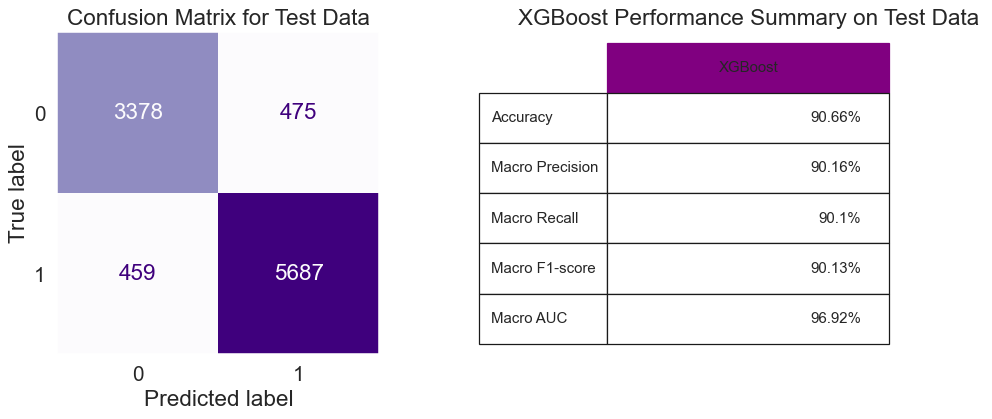

In [132]:
model_evaluation(xgb_opt, X_train, X_test, y_train, y_test, 'XGBoost')

# To check: 
the accuracy when I ran it has fallen slightly (by 1%). I wanted to clarify using randomisedCV, I understand that we did it because it is more accurate and specific for hyperparameter search spaces. I wanted to clarify because your comment says you did a GRIDSEARCHCV, but the code is for a randomisedsearchCV. Howvever, my computer is unable to run the code for hyperparameter tuning, probably due to memory issues. I don't know if there is a way to make it more efficient, or it is really just my computer.